### Read Left, Center and Right Images

In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

left = cv2.imread("./images/LeftRGB_00004001.png")
center = cv2.imread("./images/CentralRGB_00004001.png")
right = cv2.imread("./images/RightRGB_00004001.png")

left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
center = cv2.cvtColor(center, cv2.COLOR_BGR2RGB)
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 10))
labels = ['left (-45)', 'center', 'right (+45)']
for index, image in enumerate([left, center, right]):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.title(labels[index])

### Stitch images using opencv
Reference: https://docs.opencv.org/3.4/d1/d46/group__stitching.html#ga2de00132401436e7ddc89590994fd922

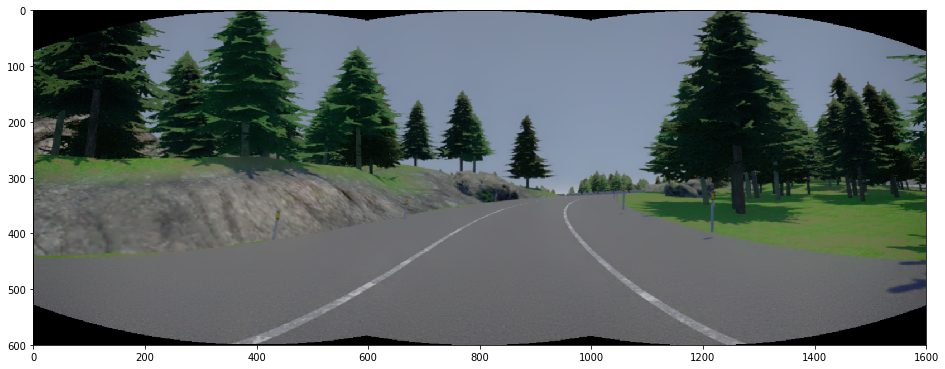

In [2]:
stitcher = cv2.Stitcher.create(0)
(status, stitched) = stitcher.stitch([left, center, right])
plt.figure(figsize=(16, 10))
stitched = cv2.resize(stitched, (1600, 600)) # resize to original height
plt.imshow(stitched) # opencv does a spherical warp

### Attempt at our own stitching
Referencing https://www.cse.wustl.edu/~ayan/courses/cse559a/PDFs/lec12.pdf

In [116]:
def cart2angular(x,theta_0=0, w=800, f=400):
    theta_0 = np.deg2rad(theta_0)
    theta = np.arctan((x-w/2)/f) - theta_0
    return theta

def angular2cart(theta, theta_0, w=800, f=400):
    theta_0 = np.deg2rad(theta_0)
    x = np.tan(theta + theta_0)*f+w/2
    return x

In [26]:
size_y = left.shape[0]
size_x = left.shape[1]

In [165]:
xy_coords = np.tile(np.arange(0,800), (size_y,1)) ## make a matrix of pixel locs
thetas_center = (cart2angular(xy_coords, 0, 800, 400))
    
thetas_left   = (cart2angular(xy_coords, +45, 800, 400))
    
thetas_right  = (cart2angular(xy_coords, -45, 800, 400))
    
thetas = [thetas_left, thetas_center, thetas_right]

In [166]:
min_theta = +np.inf
max_theta = -np.inf
for i in thetas:
    if i.min() < min_theta:
        min_theta = i.min()
    if i.max() > max_theta:
        max_theta = i.max()

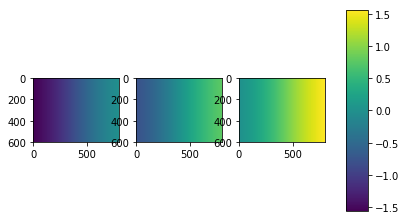

<Figure size 11520x720 with 0 Axes>

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=3)
plt.figure(figsize=(160,10))
for i in range(len(axes)):
    ax = axes.flat[i]
    im = ax.imshow(thetas[i], vmin=min_theta, vmax=max_theta)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


In [168]:
last_center_col = thetas_center[:,-1]
total_min = +np.inf
for i in range(800):
    curr_col = thetas_right[:,i]
    l1_diff = np.power((curr_col - last_center_col),2).mean()
    if l1_diff < total_min:
        total_min = l1_diff
        idx = i

In [169]:
idx

399

In [170]:
thetas_center.shape

(600, 800)

In [171]:
total = np.zeros((600,1600))
total[:,0:400] = thetas_left[:,0:400]
total[:,400:1200] = thetas_center
total[:,1200:] = thetas_right[:,400:]

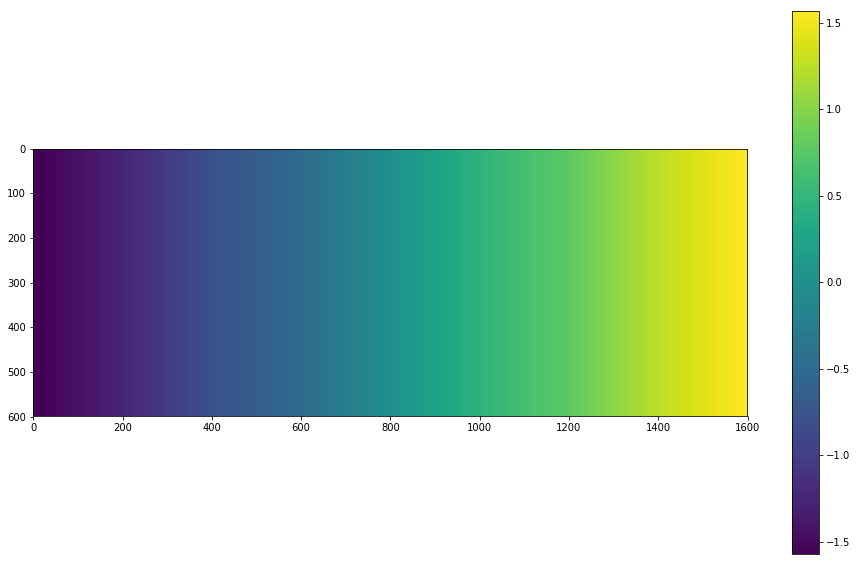

In [172]:
plt.figure(figsize=(16,10))
plt.imshow(total, vmax=max_theta, vmin=min_theta)
plt.colorbar()

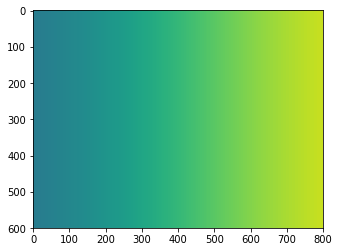

In [173]:
theta_30    = (cart2angular(xy_coords, -30, 800, 400))
last_col_30 = theta_30[:,-1]
plt.imshow(theta_30,vmin=min_theta, vmax=max_theta)

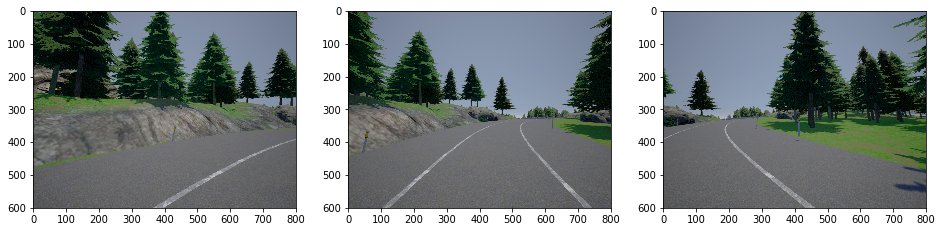

In [143]:
plt.figure(figsize=(16,10))
plt.subplot(1,3,1)
plt.imshow(left)
plt.subplot(1,3,2)
plt.imshow(center)
plt.subplot(1,3,3)
plt.imshow(right)

In [69]:
last_col = theta_30[:,-1]
right_col = theta_30[:,0]

## Finding a column that matches most

In [ ]:
total_min = +np.inf
for i in range(800):
    curr_col = thetas_right[:,i]
    l1_diff = np.power((curr_col - last_col),2).mean()
    if l1_diff < total_min:
        total_min = l1_diff
        idx = i

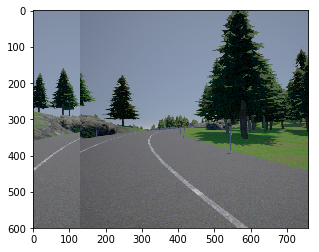

In [80]:
plt.imshow(np.hstack([center[:,293:293+130] ,right[:,0:630]]))

In [26]:
def rotation_matrix(theta):
    """theta in degrees"""
    theta = np.deg2rad(theta)
#     R = np.array([[np.cos(theta), -np.sin(theta), 0],
#                   [np.sin(theta), np.cos(theta), 0],
#                   [0, 0, 1]])
    R = np.array([[np.cos(theta), 0,  -np.sin(theta)],
                  [0, 1, 0],
                  [np.sin(theta), 0, np.cos(theta)]])
#     R = np.array([[1, 0, 0],
#                   [0, np.cos(theta), -np.sin(theta)],
#                   [0, np.sin(theta), np.cos(theta)]])
    return R

def intrinsic_matric(f, w, h):
    K = np.array([[f, 0, w/2.0],
              [0, f, h/2.0],
              [0, 0, 1]]) 
    return K

In [27]:
K = intrinsic_matric(f=400, w=800, h=600)

In [28]:
R = rotation_matrix(-45)
right_homography = np.zeros(right.shape)
for p_x in range(800):
    for p_y in range(600):
        x = np.array([p_x, p_y, 1])
        x_p = np.matmul(K*R*np.linalg.inv(K), x)
        try:
            right_homography[p_y, p_x, :] = right[int(x_p[1]), int(x_p[0]), :]
        except:
            pass

#### When we try setting the rotation angle of -45 and 45 for right and left rotation matrices respectively, it does not 

In [29]:
R = rotation_matrix(-45)
left_homography = np.zeros(left.shape)
for p_x in range(800):
    for p_y in range(600):
        x = np.array([p_x, p_y, 1])
        x_p = np.matmul(K*R*np.linalg.inv(K), x)
        try:
            left_homography[p_y, p_x, :] = left[int(x_p[1]), int(x_p[0]), :]
        except:
            pass

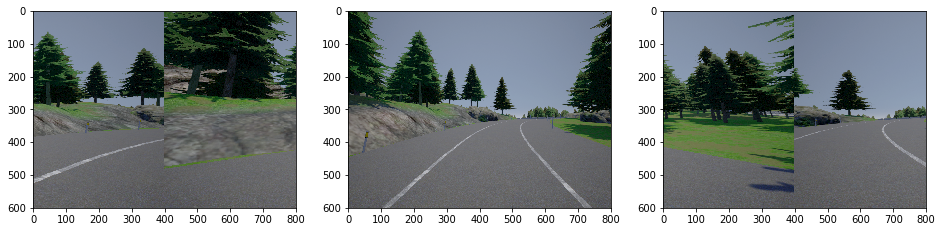

In [33]:
plt.figure(figsize=(16, 10))
for index, image in enumerate([left_homography, center, right_homography]):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image/255.0)

Text(0.5,1,'Our stitched image')

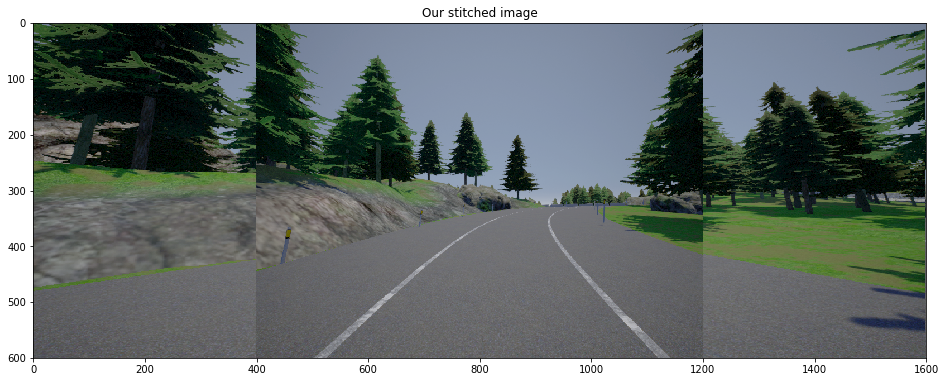

In [32]:
plt.figure(figsize=(16, 10))
our_stitch = np.zeros((600, 2*800, 3))
our_stitch[:, 400:1200, :] = center
our_stitch[:, 1200:, :] = right_homography[:, 0:400, :]
our_stitch[:, :400, :] = left_homography[:, 400:, :]
plt.imshow(our_stitch / 255.0)
plt.title("Our stitched image")

#### Notes: The seams are very apparant. So we cannot use this version of the stitched image.

### Original Comparison

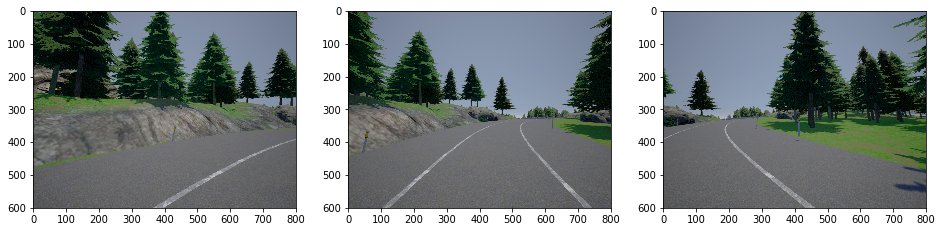

In [97]:
plt.figure(figsize=(16, 10))
for index, image in enumerate([left, center, right]):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)

### Extracting reprojected views from stitched image

(0, 1600)

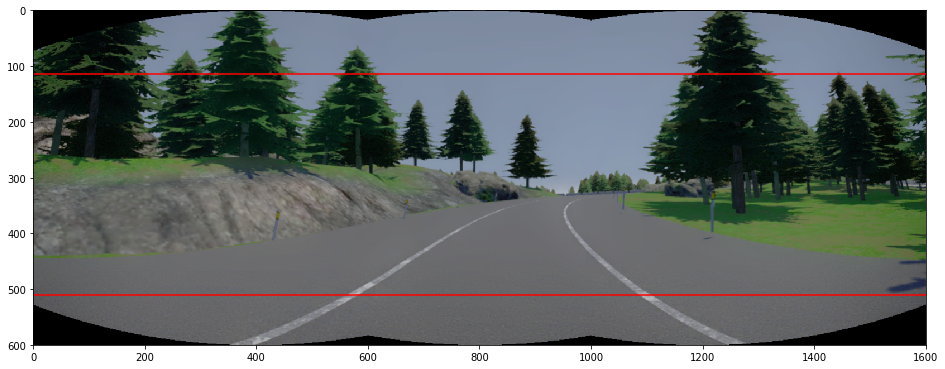

In [35]:
plt.figure(figsize=(16, 10))
plt.imshow(stitched)
plt.hlines(115, xmin=0, xmax=1600, color='r')
plt.hlines(510, xmin=0, xmax=1600, color='r')
plt.xlim([0, 1600])

#### Notes: Authors clip the images with 800x600 resolution at 115:550x600 (red lines above), and resize them to 200x88 as input to the neural network. We do not know how to extract that for different camera angles from the above image. How do we map this spherical image to cartesian to get rid of the radial distortion?